<a href="https://colab.research.google.com/github/marcosarto/titanicML/blob/main/conventional_classification/Titanic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORTS

In [1]:
DROPCOLUMNS = ["PassengerId", "Survived"]
DATAPATH = "https://raw.githubusercontent.com/marcosarto/titanicML/main/conventional_classification/data/"
OUTPUT_PATH = "sub_file/"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz
import xgboost
from numpy import random
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, roc_curve, plot_roc_curve, auc
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [5]:
data_train = pd.read_csv(DATAPATH + 'train.csv')
data_test = pd.read_csv(DATAPATH + 'test.csv')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#EDA

Matrice di correlazione dei dati numerici

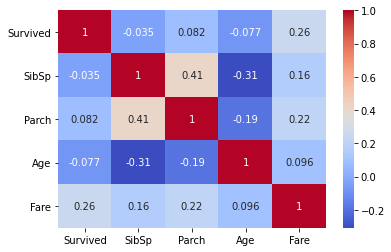

In [6]:
 g = sns.heatmap(data_train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, cmap = "coolwarm")

Sopravvivenza maschio/femmina

In [7]:
femmine_vissute=0
maschi_vissuti=0
femmine_totali=0
maschi_totali=0

for index, row in data_train.iterrows():
  if row['Sex']=='male':
    if row['Survived']==1:
      maschi_vissuti+=1
    maschi_totali+=1
  else:
    if row['Survived']==1:
      femmine_vissute+=1
    femmine_totali+=1

femmine_morte=femmine_totali-femmine_vissute
maschi_morti=maschi_totali-maschi_vissuti
print ('Ratio di sopravvivenza femminile: ', float(femmine_vissute) / float(femmine_totali))
print ('Ratio di sopravvivenza maschile: ', float(maschi_vissuti) / float(maschi_totali))

Ratio di sopravvivenza femminile:  0.7420382165605095
Ratio di sopravvivenza maschile:  0.18890814558058924


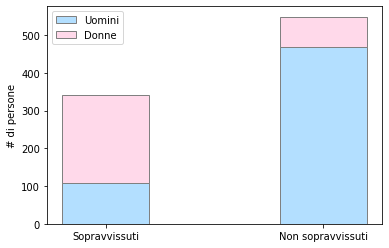

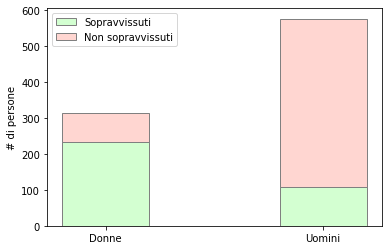

In [8]:
N = 2
women_data = (femmine_vissute, femmine_morte)
men_data = (maschi_vissuti, maschi_morti)
indice = np.arange(N)  #asse-x
width = 0.40       # larghezza

p1 = plt.bar(indice, men_data, width, facecolor='#b3dfff', edgecolor='gray', align='center')
p2 = plt.bar(indice, women_data, width, facecolor='#ffd9ea',edgecolor='gray', bottom=men_data, align='center')

plt.ylabel('# di persone')
plt.xticks(indice , ('Sopravvissuti', 'Non sopravvissuti'))
plt.legend((p1[0], p2[0]), ('Uomini', 'Donne'), loc="upper left")
plt.show()

N = 2
vissuti = (femmine_vissute, maschi_vissuti)
morti = (femmine_morte, maschi_morti)
ind = np.arange(N)    
width = 0.40       

p1 = plt.bar(indice, vissuti, width, facecolor='#d3ffd1', edgecolor='gray', align='center')
p2 = plt.bar(indice, morti, width, facecolor='#ffd6d1', edgecolor='gray', bottom=vissuti, align='center')

plt.ylabel('# di persone')
plt.xticks(ind, ('Donne', 'Uomini'))
plt.legend((p1[0], p2[0]), ('Sopravvissuti', 'Non sopravvissuti'), loc="upper left")
plt.show()

Sembra esserci una percentuale di sopravvivenza molto piu' alta per le donne rispetto agli uomini (74,2% rispetto a 18.9%).
Abbiamo individuato due possibili ragioni :
1)"Prima donne e bambini" e' una strategia reale per l'evaquazione delle barche e puo' aver permesso a quest'ultimi di prendere posto sulle scialuppe di salvataggio in maggior quantita'.
2) Una piu' grande percentuale delle donne era in possesso di biglietti di prima e seconda classe (che potrebbero risultare in una possibilita' di sopravvivenza maggiore).

Fatte queste assunzioni andiamo a vedere se si verificano indagando la percentuale di sopravvivenza rispetto alla classe del biglietto



In [9]:
prima_classe=0
seconda_classe=0
terza_classe=0

for index, row in data_train.iterrows():
  if row['Pclass']==1:
    prima_classe+=1
  elif row['Pclass']==2:
    seconda_classe+=1
  elif row['Pclass']==3:
    terza_classe+=1

#Controllo di non aver perso dati (controllo che la somma passeggeri, numero classi sia uguale):
print ("Prima classe: ", prima_classe, " Seconda classe: ", seconda_classe, " Terza classe: ", terza_classe)
print ("Il numero totale di passeggeri e' (891 se corretto): ", prima_classe + seconda_classe + terza_classe)

Prima classe:  216  Seconda classe:  184  Terza classe:  491
Il numero totale di passeggeri e' (891 se corretto):  891


In [10]:
def contaSopravvissuti(pclass):
  tot_vissuti=0
  for index, row in data_train.iterrows():
    if row['Survived']==1:
      if row['Pclass']==pclass:
        tot_vissuti+=1
  return tot_vissuti

prima_classe_sopravvissuti = contaSopravvissuti(1)
seconda_classe_sopravvissuti = contaSopravvissuti(2)
terza_classe_sopravvissuti = contaSopravvissuti(3)

ratio_prima_classe_sopravvissuti = float(prima_classe_sopravvissuti) / float(prima_classe)
ratio_seconda_classe_sopravvissuti = float(seconda_classe_sopravvissuti) / float(seconda_classe)
ratio_terza_classe_sopravvissuti = float(terza_classe_sopravvissuti) / float(terza_classe)

# Note: use %s (and not %d) to show decimal places in survival rates
print ("Sopravvissuti in prima classe : %s con un ratio : %s" % (prima_classe_sopravvissuti, float(ratio_prima_classe_sopravvissuti)))
print ("Sopravvissuti in seconda classe : %s con un ratio : %s" % (seconda_classe_sopravvissuti, float(ratio_seconda_classe_sopravvissuti)))
print ("Sopravvissuti in terza classe : %s con un ratio : %s" % (terza_classe_sopravvissuti, float(ratio_terza_classe_sopravvissuti)))

Sopravvissuti in prima classe : 136 con un ratio : 0.6296296296296297
Sopravvissuti in seconda classe : 87 con un ratio : 0.47282608695652173
Sopravvissuti in terza classe : 119 con un ratio : 0.24236252545824846


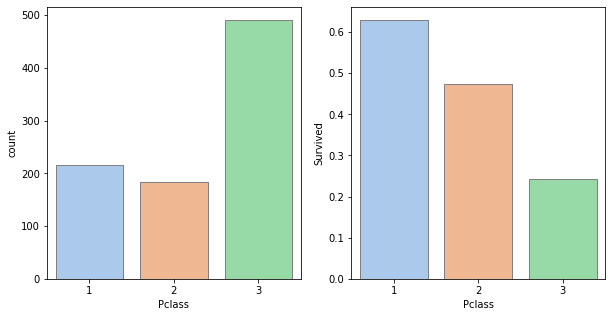

In [11]:
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# Primo grafico sopravvissuti assoluti
sns.countplot(x='Pclass', data=data_train, order=[1,2,3], ax=axis1, palette="pastel", edgecolor="gray")

# Secondo con ratio
pclass_ratio = data_train[["Pclass", "Survived"]].groupby(['Pclass'],as_index=False).mean()
# Plot the total number of passengers per class
sns.barplot(x="Pclass", y="Survived", data=pclass_ratio, label="Totale # di passeggeri", order=[1,2,3], ax=axis2, palette="pastel", edgecolor="gray");

Analizziamo ora l'eta' dei passeggeri, e come questo ha impattato la sopravvivenza

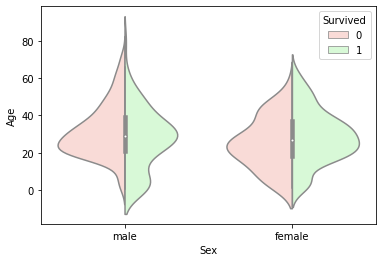

In [12]:
import math

morti_eta=list(range(81))
morti_eta[0:81]=[0]*81
eta=list(range(81))
eta[0:81]=[0]*81

for index,row in data_train.iterrows():
  if not math.isnan(row['Age']):
    eta[int(row['Age'])]+=1
  if row['Survived']==0:
    if not math.isnan(row['Age']):
      morti_eta[int(row['Age'])]+=1

#for x in range(len(morti_eta)):
#  if eta[x]==0 :
#    morti_eta[x]=0
#  else :
#    morti_eta[x]=float(morti_eta[x])/float(eta[x])

#plt.hist([eta, morti_eta], bins = 80, alpha = 1)
#lt.show()

#fig, (axis1,axis2) = plt.subplots(1,1,sharex=True,figsize=(15,7))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=data_train, split=True, palette={0: "#ffd6d1", 1: "#d3ffd1"});

#p1=plt.plot(list(range(81)), morti_eta, 'ro')
#p2=plt.plot(list(range(81)), eta, 'bo')
#plt.axis([0,80,0,35])
#plt.legend((p1[0], p2[0]), ('morti', 'totali'), loc="upper left")
#plt.show()

Il maggior numero di uomini morti era di mezz'eta', questo puo' essere per il discorso di prima del salvare donne e bambini (maschi e femmine). Controlliamo se l'essere parte di una famiglia ha impattato la sopravvivenza

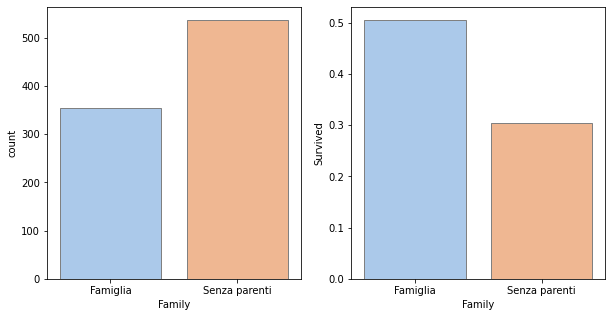

In [13]:
# Creo una nuova feature con il nome 'Family'
data_train['Family'] =  data_train['Parch'] + data_train['SibSp']
data_test['Family'] =  data_test['Parch'] + data_test['SibSp']

# La feature puo' essere riassunta con ha famiglia e non ha famiglia
# Il problema distingue il tipo di parentela ma per ora noi consideriamo tutto allo stesso modo
data_train.loc[data_train['Family'] >= 1, 'Family'] = 1
data_train.loc[data_train['Family'] == 0, 'Family'] = 0
data_test.loc[data_test['Family'] >= 1, 'Family'] = 1
data_test.loc[data_test['Family'] == 0, 'Family'] = 0
# Converto il tipo, questo rende la variabile disponibile per la heatmap volendo
data_train['Family'] = data_train['Family'].astype(int)
data_test['Family'] = data_test['Family'].astype(int)

fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# Primo grafo sommo quanti avevano famiglia o parentela come dir si voglia
sns.countplot(x='Family', data=data_train, order=[1,0], ax=axis1, palette="pastel", edgecolor="gray");

# Ratio di sopravvivenza per chi aveva famiglia e chi no
sopravvivenza_con_famiglia = data_train[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x="Family", y="Survived", data=sopravvivenza_con_famiglia, order=[1,0], ax=axis2, palette="pastel", edgecolor="gray");
axis1.set_xticklabels(["Famiglia","Senza parenti"], rotation=0);

Nonostante possa sembrare evidente il collegamento famiglia -> maggiore sopravvivenza, la metrica potrebbe essere semplicemente un prolungamento della scoperta fatta a priori che donne e bambini sono stati quelli evaquati prima.
Per controllare se era l'avere una famiglia il fattore determinante controlliamo il ratio di uomini adulti con e senza famiglia

In [14]:
#SERVE CHE VENGA CAMBIATA LA FEATURE SEX FA QUALITATIVO A QUANTITATIVO

uomini_soli = 0
uomini_famiglia = 0
uomini_soli_1 = 0
uomini_famiglia_1 = 0

for index, row in data_train.iterrows():
    if row['Sex'] == 'male' and row['Family'] == 0 and row['Age'] >= 18:
        uomini_soli += 1
        if row['Survived'] == 1:
            uomini_soli_1 += 1
    if row['Sex'] == 'male' and row['Family'] == 1 and row['Age'] >= 18:
        uomini_famiglia += 1
        if row['Survived'] == 1:
            uomini_famiglia_1 += 1

print ("Nuomero uomini soli : %s , numero uomini con famiglia : %s " % (uomini_soli, uomini_famiglia))
print ("---------")

# Ratio
print ('Sopravvivenza uomini soli : ', float(uomini_soli_1) / float(uomini_soli))
print ('Sopravvivenza uomini con famiglia : ', float(uomini_famiglia_1) / float(uomini_famiglia))

Nuomero uomini soli : 292 , numero uomini con famiglia : 103 
---------
Sopravvivenza uomini soli :  0.17123287671232876
Sopravvivenza uomini con famiglia :  0.1941747572815534


Non sembra esserci correlazione evidente 

Controlliamo se il sito di imbarco ha determinanza sul target

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


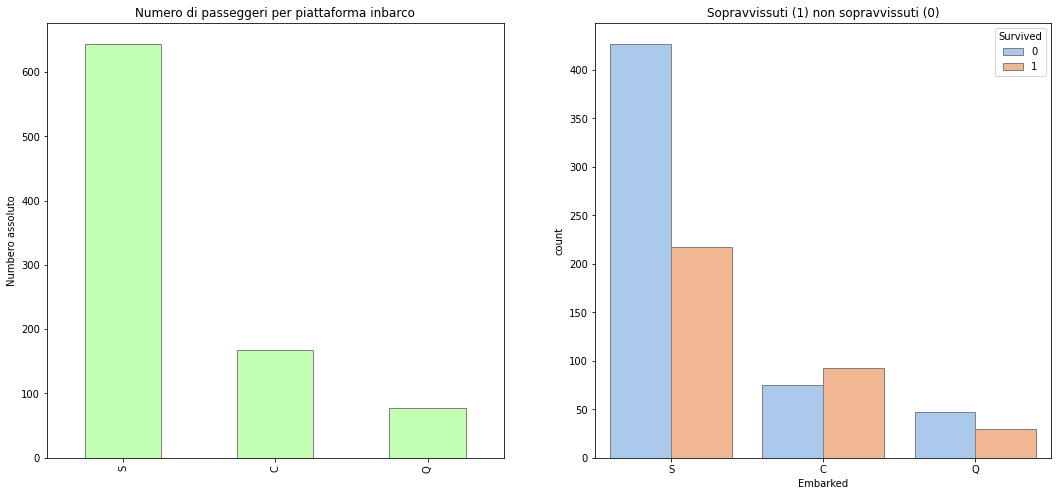

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))
data_train["Embarked"].value_counts().plot.bar(color = "#c3ffb3", ax = ax[0], edgecolor="gray")
ax[0].set_title("Numero di passeggeri per piattaforma inbarco")
ax[0].set_ylabel("Numbero assoluto")
sns.countplot("Embarked", hue = "Survived", data = data_train, ax = ax[1], palette="pastel", edgecolor="gray")
ax[1].set_title("Sopravvissuti (1) non sopravvissuti (0)")
plt.show()

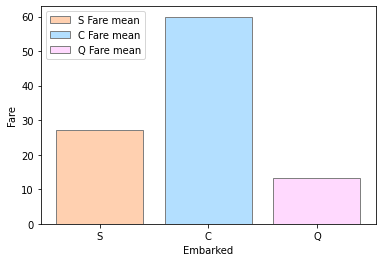

In [16]:
S_fare = data_train[data_train.Embarked=='S'].Fare.mean()
C_fare = data_train[data_train.Embarked=='C'].Fare.mean()
Q_fare = data_train[data_train.Embarked=='Q'].Fare.mean()
plt.bar(x='S', height=S_fare, facecolor='#ffd0b0', edgecolor='gray', align='center')
plt.bar(x='C', height=C_fare, facecolor='#b3dfff', edgecolor='gray', align='center')
plt.bar(x='Q', height=Q_fare, facecolor='#ffd9fe', edgecolor='gray', align='center')
plt.ylabel('Fare')
plt.xlabel('Embarked')
plt.legend(("S Fare mean","C Fare mean","Q Fare mean"),loc="upper left")
plt.show()

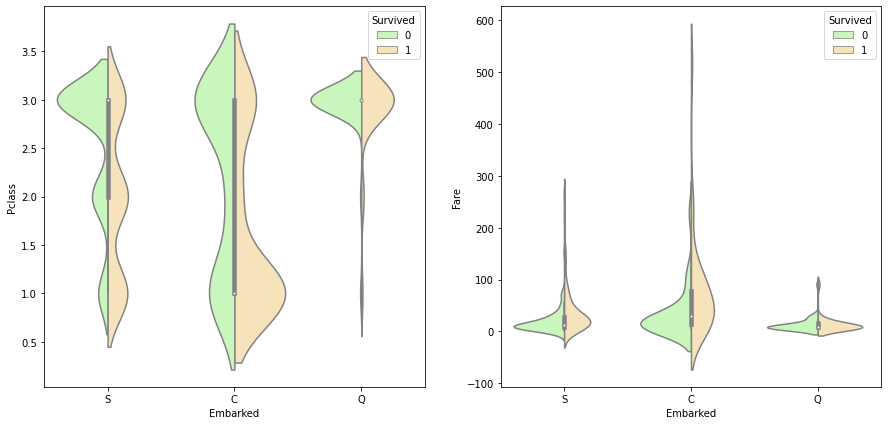

In [17]:
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(15,7))
sns.violinplot(x='Embarked', y='Pclass', hue='Survived', data=data_train, split=True, palette={0: "#c3ffb3", 1: "#ffe6b3"}, ax=axis1)
sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=data_train, split=True, palette={0: "#c3ffb3", 1: "#ffe6b3"}, ax=axis2)

Sembrerebbe che una sopravvivenza maggiore nell'imbarco C sia da attribuire al costo del biglietto piu' che all'imbarco effettivo. (In maniera minore si puo' vedere anche in S)

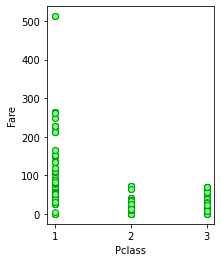

In [18]:
plt.figure(figsize=(3,4))
plt.scatter(data_train['Pclass'],data_train['Fare'], color="#75ff7c", edgecolors="#009e08")
plt.xticks(range(1,4))
plt.ylabel('Fare')
plt.xlabel('Pclass')
plt.show()
#Cancello il valore in alto a sinistra, sembra outlier
#data_train.Fare.loc[data_train['Fare'] > 400] = np.nan
#plt.show()

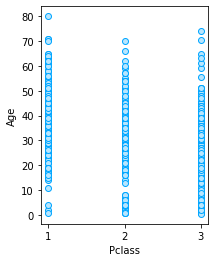

In [19]:
plt.figure(figsize=(3,4))
plt.scatter(data_train['Pclass'],data_train['Age'], color="#b8e6ff", edgecolors="#00a6ff")
plt.xticks(range(1,4))
plt.ylabel('Age')
plt.xlabel('Pclass')
plt.show()

#FEATURE ENGINEERING

Fill valori

In [20]:
# Estraggo il target per poi rimuoverlo che non e' presente nel test
targets = data_train.Survived
data_train.drop(['Survived'], 1, inplace=True)
    
# Unisco train e test, inoltre droppo PassengerId perche' non e' utile
combined = data_train.append(data_test)
combined.reset_index(inplace=True)
combined.drop(['index', 'PassengerId'], inplace=True, axis=1)
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [21]:
#Train
print('Missing values del train')
for i in range(len(data_train.columns)):
  missing_data = data_train[data_train.columns[i]].isna().sum()
  perc = missing_data / len(data_train) * 100
  print(data_train.columns[i] + ' --- missing values: %d, percentage %.2f' % (missing_data, perc))

#Test
print('')
print('Missing values del test')
for i in range(len(data_test.columns)):
  missing_data = data_test[data_test.columns[i]].isna().sum()
  perc = missing_data / len(data_test) * 100
  print(data_test.columns[i] + ' --- missing values: %d, percentage %.2f' % (missing_data, perc))

Missing values del train
PassengerId --- missing values: 0, percentage 0.00
Pclass --- missing values: 0, percentage 0.00
Name --- missing values: 0, percentage 0.00
Sex --- missing values: 0, percentage 0.00
Age --- missing values: 177, percentage 19.87
SibSp --- missing values: 0, percentage 0.00
Parch --- missing values: 0, percentage 0.00
Ticket --- missing values: 0, percentage 0.00
Fare --- missing values: 0, percentage 0.00
Cabin --- missing values: 687, percentage 77.10
Embarked --- missing values: 2, percentage 0.22
Family --- missing values: 0, percentage 0.00

Missing values del test
PassengerId --- missing values: 0, percentage 0.00
Pclass --- missing values: 0, percentage 0.00
Name --- missing values: 0, percentage 0.00
Sex --- missing values: 0, percentage 0.00
Age --- missing values: 86, percentage 20.57
SibSp --- missing values: 0, percentage 0.00
Parch --- missing values: 0, percentage 0.00
Ticket --- missing values: 0, percentage 0.00
Fare --- missing values: 1, perce

Gestisco dati mancanti per "Cabin" (687 missing values)

In [22]:
# riempio i missing values con la lettera U = Unknown
combined.Cabin.fillna('U', inplace=True)

# creo due insiemi vuoti per vedere che lettere ci sono nel train e nel test
train_cabin, test_cabin = set(), set()

# passo il train (combined fino a 891) e metto il primo carattere c[0] nell'insieme
for c in combined.iloc[:891]['Cabin']:
    if(c[0] != 'U'):
      train_cabin.add(c[0])
# stesso per il test
for c in combined.iloc[891:]['Cabin']:
    if(c[0] != 'U'):
      test_cabin.add(c[0])

# li stampo e vedo se i valori nel test ci sono tutti nel train
print("Train -> ",sorted(train_cabin))
print("Test  -> ",sorted(test_cabin))

Train ->  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
Test  ->  ['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [23]:
# mappo i valori di cabin con la loro prima lettera
combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])

Controllo la distribuzione dei tipi di cabina in base alla classe dei passeggeri

In [24]:
print(combined.iloc[:891].groupby('Pclass').Cabin.value_counts())
print(combined.iloc[891:].groupby('Pclass').Cabin.value_counts())

Pclass  Cabin
1       C         59
        B         47
        U         40
        D         29
        E         25
        A         15
        T          1
2       U        168
        F          8
        D          4
        E          4
3       U        479
        F          5
        G          4
        E          3
Name: Cabin, dtype: int64
Pclass  Cabin
1       C         35
        U         27
        B         18
        D         11
        E          9
        A          7
2       U         86
        F          5
        D          2
3       U        214
        F          3
        G          1
Name: Cabin, dtype: int64


Assegno ai missing values di ogni classe il valore più comune

In [25]:
def probability_distribution(a):
 elements_count = {}

 for i in a:
   if i in elements_count:
       elements_count[i] += 1
   else:
       elements_count[i] = 1

 sol = []
 for i in np.unique(a):
   sol.append(elements_count.get(i)/len(a))
  
 return sol

def fill_feature(feature):

 feature_not_null = feature[np.logical_not(pd.isna(feature))]
 feature_unique = np.unique(feature_not_null)
 a = probability_distribution(feature_not_null)
 b = random.choice(feature_unique, size=None, replace=True, p=a)

 for i in range(len(feature)):
   if pd.isna(feature.iloc[i]):
    feature[i] = random.choice(feature_unique, size=None, replace=True, p=a)

 return feature
combined.loc[combined['Cabin'] == 'U','Cabin'] = np.nan

to_clear=combined.iloc[:891].Cabin
to_clear = to_clear.replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], [1, 2, 3, 4, 5, 6, 7, 8])
cleared = fill_feature(to_clear)
cleared = cleared.replace([1, 2, 3, 4, 5, 6, 7, 8],['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
combined.iloc[:891].Cabin = cleared

to_clear2=combined.iloc[891:].Cabin
to_clear2 = to_clear2.replace(['A', 'B', 'C', 'D', 'E', 'F', 'G'], [1, 2, 3, 4, 5, 6, 7])
cleared2 = fill_feature(to_clear2)
cleared2 = cleared2.replace([1, 2, 3, 4, 5, 6, 7],['A', 'B', 'C', 'D', 'E', 'F', 'G'])
combined.iloc[891:].Cabin = cleared2

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [26]:
print(combined.iloc[:891].groupby('Pclass').Cabin.value_counts())
print(combined.iloc[891:].groupby('Pclass').Cabin.value_counts())

Pclass  Cabin
1       C         70
        B         58
        D         39
        E         27
        A         19
        F          2
        T          1
2       C         57
        B         46
        D         30
        E         22
        F         14
        A         10
        G          4
        T          1
3       C        145
        B        105
        D         80
        E         69
        A         44
        F         31
        G         14
        T          3
Name: Cabin, dtype: int64
Pclass  Cabin
1       C        35
        B        18
        D        11
        E         9
        A         7
2       F         5
        D         2
3       F         3
        G         1
Name: Cabin, dtype: int64


Faccio il dummy coding

In [27]:
# dummy encoding creo una colonna di valori binari per ogni possibile valore della feature
cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
combined = pd.concat([combined, cabin_dummies], axis=1)

# elimino la colonna cabin che non mi serve più
combined.drop('Cabin', axis=1, inplace=True)

Riempimento della feature 'fare' con la media fatta solo sui dati di test

In [28]:
combined.iloc[:891].Fare.fillna(combined.iloc[:891].Fare.median(), inplace=True)
combined.iloc[891:].Fare.fillna(combined.iloc[891:].Fare.median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Estraggo i titoli dai nomi, e sostituisco i titoli che appaiono meno con alcuni più comuni e comprensivi

In [29]:
titles = set()
for name in data_train['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

#PRESO DA INTERNET, Molti dei titoli usati non sono piu' oggi di uso comune
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",
}

nome = combined['Name']
titolo = []
for i in range(len(nome)):
  titolo.append(Title_Dictionary[nome[i].split(',')[1].split('.')[0].strip()])

combined['Title']=titolo
combined.groupby(['Title','Sex']).count()

Pclass  Name  Age  SibSp  ...  Cabin_E  Cabin_F  Cabin_G  Cabin_T
Title   Sex                               ...                                    
Master  male        61    61   53     61  ...       61       61       61       61
Miss    female     262   262  212    262  ...      262      262      262      262
Mr      male       757   757  581    757  ...      757      757      757      757
Mrs     female     200   200  172    200  ...      200      200      200      200
Officer female       1     1    1      1  ...        1        1        1        1
        male        22    22   21     22  ...       22       22       22       22
Royalty female       3     3    3      3  ...        3        3        3        3
        male         3     3    3      3  ...        3        3        3        3

[8 rows x 17 columns]

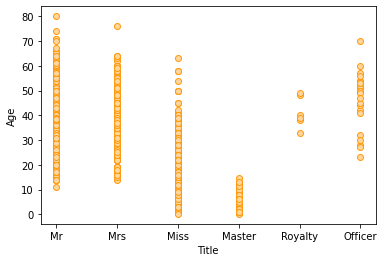

In [30]:
plt.scatter(combined['Title'],combined['Age'], color="#ffd69c", edgecolors="#ff9a0d")
plt.ylabel('Age')
plt.xlabel('Title')
plt.show()

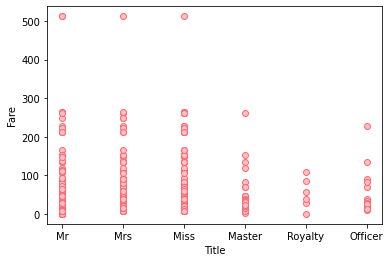

In [31]:
plt.scatter(combined['Title'],combined['Fare'], color="#ffbfc3", edgecolors="#ff6973")
plt.ylabel('Fare')
plt.xlabel('Title')
plt.show()

In [32]:
cabin_dummies = pd.get_dummies(combined['Title'], prefix='Title')    
combined = pd.concat([combined, cabin_dummies], axis=1)

combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1,0,0,0,0,0,0,Mr,0,0,1,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,0,0,1,0,0,0,0,0,Mrs,0,0,0,1,0,0
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1,0,0,0,0,0,0,Miss,0,1,0,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,0,0,1,0,0,0,0,0,Mrs,0,0,0,1,0,0
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,0,0,0,1,0,0,0,0,Mr,0,0,1,0,0,0


Fillo dati età

In [33]:
# group by Sex, Pclass, and Title 
grouped_train = combined.iloc[:891].groupby(['Sex', 'Title'])  
grouped_test = combined.iloc[891:].groupby(['Sex', 'Title']) 
# view the median Age by the grouped features 
grouped_train.Age.median()
grouped_test.Age.median()

Sex     Title  
female  Miss       22.0
        Mrs        36.5
        Royalty    39.0
male    Master      7.0
        Mr         28.5
        Officer    47.0
Name: Age, dtype: float64

In [34]:
# #apply the grouped median value on the Age NaN
combined.iloc[:891].Age = grouped_train.Age.apply(lambda x: x.fillna(x.median()))
combined.iloc[891:].Age = grouped_test.Age.apply(lambda x: x.fillna(x.median()))

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Aggiusto la famiglia per dargli piu specializzazione

In [35]:
combined.drop('Family', axis=1, inplace=True)
combined.drop('Title', axis=1, inplace=True)

combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

In [36]:
#Aggiungere dummy variables secondariamente
most_embarked = combined.Embarked.value_counts().index[0]
combined.Embarked = combined.Embarked.fillna(most_embarked)
embarked_dummies = pd.get_dummies(combined['Embarked'], prefix="Embarked")
combined = pd.concat([combined, embarked_dummies], axis=1)
combined.drop(['Embarked'], inplace=True, axis=1)

Metto le dummy variables per il Pclass

In [37]:
pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")

combined = pd.concat([combined, pclass_dummies],axis=1)
    
combined.drop('Pclass',axis=1,inplace=True)

In [38]:
print('')
print('Missing values del combined')
for i in range(len(combined.columns)):
  missing_data = combined[combined.columns[i]].isna().sum()
  perc = missing_data / len(combined) * 100
  print(combined.columns[i] + ' --- missing values: %d, percentage %.2f' % (missing_data, perc))


Missing values del combined
Name --- missing values: 0, percentage 0.00
Sex --- missing values: 0, percentage 0.00
Age --- missing values: 0, percentage 0.00
SibSp --- missing values: 0, percentage 0.00
Parch --- missing values: 0, percentage 0.00
Ticket --- missing values: 0, percentage 0.00
Fare --- missing values: 0, percentage 0.00
Cabin_A --- missing values: 0, percentage 0.00
Cabin_B --- missing values: 0, percentage 0.00
Cabin_C --- missing values: 0, percentage 0.00
Cabin_D --- missing values: 0, percentage 0.00
Cabin_E --- missing values: 0, percentage 0.00
Cabin_F --- missing values: 0, percentage 0.00
Cabin_G --- missing values: 0, percentage 0.00
Cabin_T --- missing values: 0, percentage 0.00
Title_Master --- missing values: 0, percentage 0.00
Title_Miss --- missing values: 0, percentage 0.00
Title_Mr --- missing values: 0, percentage 0.00
Title_Mrs --- missing values: 0, percentage 0.00
Title_Officer --- missing values: 0, percentage 0.00
Title_Royalty --- missing values:

Divido test e combine

Trasformazione sesso

In [39]:
combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})

Processiamo Ticket

In [40]:
combined.drop(['Name'], inplace=True, axis=1)
combined.drop(['Ticket'], inplace=True, axis=1)

In [41]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv(DATAPATH+'train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

train_full, test, target = recover_train_test_target()
train_full.head()
len(train_full.columns)

26

#MODEL

Ricapitolando: <br>
**train_full** -> dati di train <br>
**test** -> dati di test <br>
**target** -> colonna target del train <br>
**X_train** -> dati di train splittati (train) <br>
**X_test** -> dati di train splittati (test) <br>
**y_train** -> target del train splittato (train) <br>
**y_test** -> target del train splittato (test)<br>
Tutti sono fillati


Splitto i dati di training per avere un test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    train_full, target, train_size=0.7, random_state=42
)

Dimensioni a confronto

In [43]:
print(train_full['Age'].count())
print(X_train['Age'].count())
print(X_test['Age'].count())
print(len(y_train))
print(len(y_test))

891
623
268
623
268


##Decision tree

###semplice

In [44]:
dtc = DecisionTreeClassifier(max_depth=3, random_state=42)
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.8246268656716418

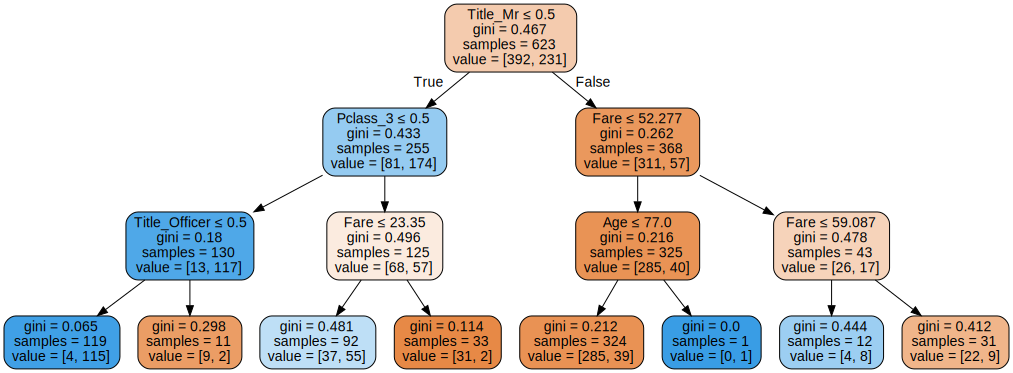

In [45]:
# Visualize Decision Tree
dot_data = export_graphviz(
    decision_tree=dtc,
    out_file="decision_tree.dot",
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

# Read the dot graph and display image
with open("decision_tree.dot") as img:
    tree = img.read()

# display(graphviz.Source(dot_graph))
display(graphviz.Source(tree))

Computo la ROC curve

<function matplotlib.pyplot.show>

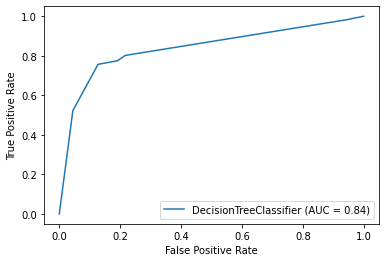

In [46]:
plot_roc_curve(dtc, X_test, y_test)
plt.show

Provo a usare la cross validation



In [47]:
cv_scores = cross_val_score(
    dtc, train_full, target, cv=20, scoring="accuracy", verbose=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


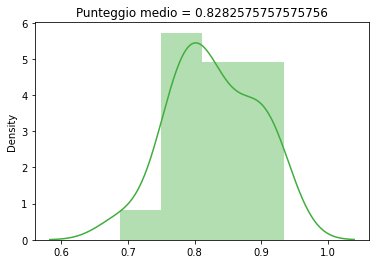

In [48]:
sns.distplot(cv_scores, color="#40ad3d");
plt.title("Punteggio medio = {}".format(np.mean(cv_scores)));

In [49]:
dtc.fit(train_full, target)
y_pred_dtc=dtc.predict(test)
#y_pred_dtc

###con grid search

In [50]:
dtc_grid = DecisionTreeClassifier(random_state=42)
# Create the parameter grids
parameter_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [3, 4, 5, 6, 7],
    "max_features": ["auto", "sqrt", "log2", None],
    "random_state": [42, 2021]
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=20)
cross_validation.get_n_splits(train_full,target)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=dtc_grid,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(train_full, target)

Fitting 20 folds for each of 160 candidates, totalling 3200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed:   25.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=20, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              pres...
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7],
                         'max_fea

In [51]:
print("Migliore score: {}".format(grid_search.best_score_))
print("Migliori parametri: {}".format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Migliore score: 0.8374242424242425
Migliori parametri: {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'random_state': 2021, 'splitter': 'random'}


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2021, splitter='random')

In [52]:
best_dtc.fit(train_full, target)
best_dtc.score(train_full, target)

0.8664421997755332

In [53]:
y_pred_dtc_grid = best_dtc.predict(test)
#y_pred_dtc_grid

<function matplotlib.pyplot.show>

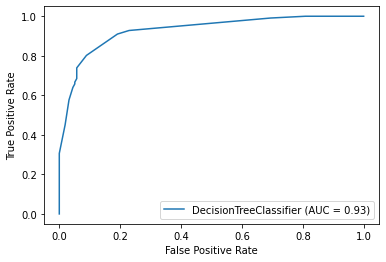

In [54]:
plot_roc_curve(best_dtc, X_test, y_test)
plt.show

##Neural Networks

###Semplice rete neurale con uno strato nascosto

Uso il train splittato per avere un test

In [55]:
# Initialize the constructor
neural_model = Sequential()
# Add an input layer
neural_model.add(Dense(26, activation="relu", input_shape=(26,)))
# Add one hidden layer
neural_model.add(Dense(20, activation="relu"))
# Add an output layer
neural_model.add(Dense(1, activation="sigmoid"))

In [56]:
EPOCHS = 30
VAL_SIZE = 0.3
BATCH_SIZE = 80

In [57]:
neural_model.compile(
    loss="binary_crossentropy",
    optimizer="SGD",
    metrics=["accuracy", tf.keras.metrics.AUC()],
)

training_phase = neural_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SIZE,
    verbose=1,
)

Epoch 1/30
6/6 [==============================] - 1s 69ms/step - loss: 1.3624 - accuracy: 0.6468 - auc: 0.6126 - val_loss: 2.6097 - val_accuracy: 0.3636 - val_auc: 0.6657
Epoch 2/30
6/6 [==============================] - 0s 7ms/step - loss: 1.1570 - accuracy: 0.6239 - auc: 0.6101 - val_loss: 0.9272 - val_accuracy: 0.3476 - val_auc: 0.5060
Epoch 3/30
6/6 [==============================] - 0s 7ms/step - loss: 0.7116 - accuracy: 0.6422 - auc: 0.6298 - val_loss: 0.7698 - val_accuracy: 0.5829 - val_auc: 0.6670
Epoch 4/30
6/6 [==============================] - 0s 7ms/step - loss: 0.6527 - accuracy: 0.6812 - auc: 0.6630 - val_loss: 0.7451 - val_accuracy: 0.6524 - val_auc: 0.6533
Epoch 5/30
6/6 [==============================] - 0s 6ms/step - loss: 0.6674 - accuracy: 0.7064 - auc: 0.6965 - val_loss: 0.6952 - val_accuracy: 0.6471 - val_auc: 0.6473
Epoch 6/30
6/6 [==============================] - 0s 6ms/step - loss: 0.6222 - accuracy: 0.7087 - auc: 0.6919 - val_loss: 0.6945 - val_accuracy: 0.56

loss


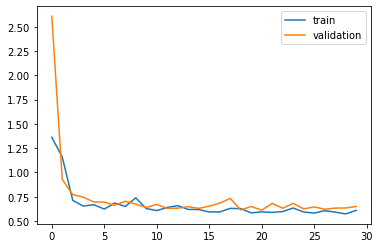

Accuracy


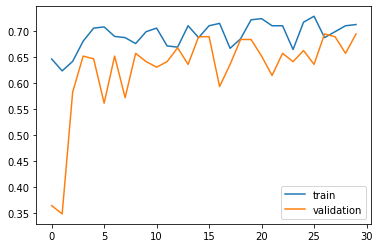

In [58]:
# plot training history
print("loss")
plt.plot(training_phase.history["loss"], label="train")
plt.plot(training_phase.history["val_loss"], label="validation")
plt.legend()
plt.show()
print("Accuracy")
plt.plot(training_phase.history["accuracy"], label="train")
plt.plot(training_phase.history["val_accuracy"], label="validation")
plt.legend()
plt.show()

In [59]:
y_pred = neural_model.predict(X_test)
y_predicted = np.round(y_pred).astype(int)
y_predicted = np.squeeze(y_predicted)
print(y_predicted)

[0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1
 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1
 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 0 1 1 0 0 0 0 0 0]


In [60]:
print(confusion_matrix(y_test, y_predicted))

print("Classification Report:")
print(classification_report(y_test, y_predicted))

[[141  16]
 [ 62  49]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       157
           1       0.75      0.44      0.56       111

    accuracy                           0.71       268
   macro avg       0.72      0.67      0.67       268
weighted avg       0.72      0.71      0.69       268



Computo la ROC Curve

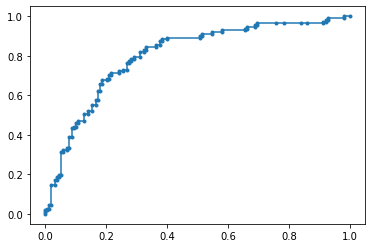

In [61]:
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

###Uso la grid search per il Parameter Tuning

Nell'ultima riga del blocco sotto c'è un problema che ti dicevo, abbiamo usato sempre nomi uguali e perdiamo i dati iniziali, dobbiamo cambiare un po' i nomi così che non si sovrascrivano e non abbiano problemi

Lui usa il preprocessor che è una funzione costruita da lui per gestire i dati di quel notebook che non va bene per il nostro, quindi l'ho escluso. C'è da controllare se va tutto bene lo stesso

In [62]:
# Create the parameter grids
#parameter_grid = {
#    "hidden_units": [(26, 15), (16, 10)],
#    "hidden_activation": ["relu", "sigmoid"],
#    "epochs": [20, 25, 30, 35],
#    "batch_size": [50, 80, 100],
#    "verbose": [0],
#}

# Create Stratified folds
#cross_validation = StratifiedKFold(n_splits=3)
#cross_validation.get_n_splits(train_full, target)

# Create the scoring dictionary
#SCORING = {
#    "accuracy": "accuracy",
#    "balanced_accuracy": "balanced_accuracy",
#    "f1": "f1_macro",
#}

# Create and fit the GridSearchCV
#grid_search = GridSearchCV(
    #estimator=clf,
#    estimator=keras_model_classifier,
#    param_grid=parameter_grid,
#    cv=cross_validation,
#    verbose=1,
#    scoring=SCORING,
#    return_train_score=False,  # True,
#    refit="accuracy",
#)

# You can use X_train without manual preprocessing because preprocessor is built-in the classifier pipeline
#grid_search.fit(train_full, target)

In [63]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_clf = grid_search.best_estimator_
best_clf

# Best score: 0.712682379349046
# Best parameters: {'batch_size': 50, 'epochs': 30, 'hidden_activation': 'relu', 'hidden_units': (26, 15), 'verbose': 0}

Best score: 0.8374242424242425
Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'random_state': 2021, 'splitter': 'random'}


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2021, splitter='random')

In [64]:
best_clf.score(train_full, target)

0.8664421997755332

In [65]:
y_pred = best_clf.predict(train_full)
print("Confusion Matrix:")
print(confusion_matrix(target, y_pred))

print("Classification Report:")
print(classification_report(target, y_pred))

Confusion Matrix:
[[522  27]
 [ 92 250]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       549
           1       0.90      0.73      0.81       342

    accuracy                           0.87       891
   macro avg       0.88      0.84      0.85       891
weighted avg       0.87      0.87      0.86       891



##Ensemble methods

###Voting classifier

In [66]:
dtc_clf = DecisionTreeClassifier(random_state=42, max_depth=6)
log_clf = LogisticRegression(solver="lbfgs", random_state=42, max_iter=700)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('dtc', dtc_clf), ('lg', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [67]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=6,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=42,
       

In [68]:
for clf in (dtc_clf, log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.8022388059701493
LogisticRegression 0.8134328358208955
RandomForestClassifier 0.7985074626865671
SVC 0.6604477611940298
VotingClassifier 0.7985074626865671


In [69]:
for clf in (dtc_clf, log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(train_full, target)
y_pred_hardVot = voting_clf.predict(test)
#y_pred_hardVot

con soft voting

In [70]:
dtc_clf = DecisionTreeClassifier(random_state=42, max_depth=6)
log_clf = LogisticRegression(solver="lbfgs", random_state=42, max_iter=700)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability=True)

soft_voting_clf = VotingClassifier(
    estimators=[('dtc', dtc_clf), ('lg', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
soft_voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=6,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=42,
       

In [71]:
for clf in (dtc_clf, log_clf, rnd_clf, svm_clf, soft_voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.8022388059701493
LogisticRegression 0.8134328358208955
RandomForestClassifier 0.7985074626865671
SVC 0.6604477611940298
VotingClassifier 0.8059701492537313


In [72]:
for clf in (log_clf, log_clf, rnd_clf, svm_clf, soft_voting_clf):
    clf.fit(train_full, target)
y_pred_softVot = soft_voting_clf.predict(test)
#y_pred_softVot

###Bagging

In [73]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=150,
    max_samples=150, bootstrap=True, random_state=42, oob_score=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [74]:
print(accuracy_score(y_test, y_pred))

0.8171641791044776


In [75]:
bag_clf.fit(train_full, target)
y_pred_bagging = bag_clf.predict(test)
#y_pred_bagging

Out of Bag evaluation

In [76]:
bag_clf.oob_score_

0.8260381593714927

In [77]:
bag_clf.oob_decision_function_[:10]

array([[0.9338843 , 0.0661157 ],
       [0.024     , 0.976     ],
       [0.58333333, 0.41666667],
       [0.03816794, 0.96183206],
       [0.92366412, 0.07633588],
       [0.82539683, 0.17460317],
       [0.77419355, 0.22580645],
       [0.62204724, 0.37795276],
       [0.56818182, 0.43181818],
       [0.03875969, 0.96124031]])

###Random Forests

In [78]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=150, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [79]:
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.8283582089552238

In [80]:
rnd_clf.fit(train_full, target)
y_pred_randf = rnd_clf.predict(test)
#y_pred_randf

###AdaBoost

In [81]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=220,
    algorithm="SAMME.R", learning_rate=0.1, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [82]:
y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8246268656716418

In [83]:
ada_clf.fit(train_full, target)
y_pred_ada = ada_clf.predict(test)
#y_pred_ada

###Gradient Boosting

In [84]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=180, learning_rate=0.1, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=180,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [85]:
y_pred = gbrt.predict(X_test)
y_predicted = np.round(y_pred).astype(int)
y_predicted = np.squeeze(y_predicted)

In [86]:
print(accuracy_score(y_test, y_predicted))

0.8246268656716418


In [87]:
gbrt.fit(train_full, target)
y_pred_gboost = gbrt.predict(test)
y_predicted_gb = np.round(y_pred_gboost).astype(int)
y_predicted_gb = np.squeeze(y_predicted_gb)

###XGBoost

In [88]:
xgb_reg = xgboost.XGBRegressor(random_state=42,objective ='reg:squarederror')
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
val_error = mean_squared_error(y_test, y_pred)
print("Validation MSE:", val_error)           
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy)

Validation MSE: 0.135132132468026
Accuracy:  0.8208955223880597


In [89]:
xgb_reg.fit(train_full, target)
y_pred_xgb = xgb_reg.predict(test)
predictions_xgb = [round(value) for value in y_pred_xgb]
#predictions_xgb

#Creazione della submission

In [90]:
sub = pd.DataFrame(columns=['PassengerId','Survived'])
prova=pd.read_csv(DATAPATH + 'test.csv')
passengerId=prova['PassengerId']

#y_test_pred=neural_model.predict(data_test)

kaggle = pd.DataFrame({'PassengerId': passengerId, 'Survived': y_pred_softVot})
kaggle.to_csv('softVot.csv', index=False)